Import functions 

In [134]:
#%matplotlib widget
import pycbc
from pycbc import waveform, conversions, filter, types, distributions, detector, psd
import matplotlib.pyplot as plt
import numpy as np
import mass as mass
import functions as func
import injections as inj
import scipy
import seaborn as sns
import importlib
from random import randrange
import time
import h5py
import matplotlib.gridspec as gridspec

#plt.rcParams.update({
#    "text.usetex": True})
importlib.reload(func)
importlib.reload(inj)

<module 'injections' from '/work/rahul.dhurkunde/HM_and_precession/libraries/injections.py'>

Read the Template Bank and initialize some variables

In [39]:
delta_f = 1/32
delta_t = 1.0/4096
f_min  = 25.0
#tb = func.read_tb("banks/vanilla_BBHbank", f_min)
tb = func.read_tb("banks/baseline_bank.hdf", f_min)
func.get_mass_ranges_from_TB(tb)

5.000003 29.997854 1.0000103 2.9999504


(5.000003, 29.997854, 1.0000103, 2.9999504)

Read injections from a file

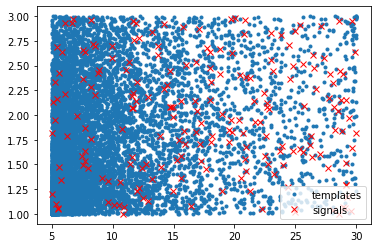

In [143]:
nsignal = 200
approximant = 'TaylorF2'
#filename = 'libraries/random_injections.hdf5'
filename = 'injections/baseline_injs.hdf'

sg = inj.read_injections_HDF(filename, nsignal, f_min)
tb_m1 = [x.m1 for x in tb]
tb_m2 = [x.m2 for x in tb]
plt.plot(tb_m1, tb_m2, '.', label='templates')
sg_m1 = [x.m1 for x in sg]
sg_m2 = [x.m2 for x in sg]
plt.plot(sg_m1, sg_m2, 'x', color='red', label = 'signals')
plt.legend()
plt.show()

Tau distributions

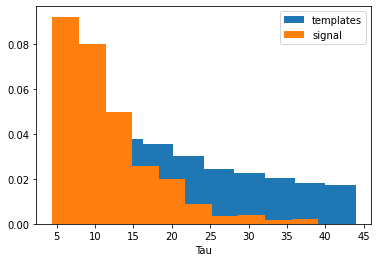

In [110]:
sg_tau = np.array([x.tau0 for x in sg])
tb_tau = np.array([x.tau0 for x in tb])
plt.hist(tb_tau, density = True, bins = 10, label = 'templates')
plt.hist(sg_tau, density = True, label = 'signal')
plt.xlabel('Tau')
plt.legend()
plt.show()

Read FULL bank matches from files

Max tau difference 0.7342931132636288


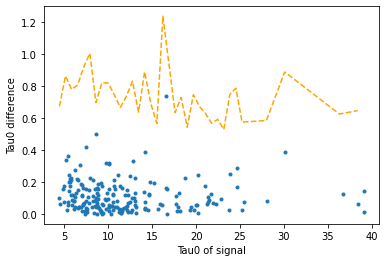

In [146]:
best_template = []
ff_array = []
tau_diff = []
sg_tau0 = []
for i in range(nsignal):
    filename = 'matches/full_matches/TF2_%s.hdf' %i
    hf = h5py.File(filename, 'r')
    matches = np.array(hf['match'])
    t_indices = np.array(hf['t_ind'])
    max_ind = np.argmax(matches)
    ff_array.append(matches[max_ind])
    best_template.append(tb[t_indices[max_ind]].tau0)
    tau_diff.append(abs(sg[i].tau0 - best_template[i]))
    sg_tau0.append(sg[i].tau0)
    #max_ind = np.argmax(temp_match)
    #match_array.append(temp_match)
    #ff_array.append(temp_match[max_ind])
    #
    #sg_tau0.append(sg[i].tau0)
    #ff_tb_tau0.append(tb[max_ind].tau0)

plt.plot(sg_tau0, tau_diff, '.')
plt.xlabel('Tau0 of signal')
plt.ylabel('Tau0 difference')
#plt.axhline(y=0.3, color = 'red')
#plt.title('Tau0 diff btw signal and best match template for 20 signals')
print('Max tau difference', max(tau_diff))
#print(len(match_array[1]), tau_diff[28], sg[28].tau0, tb[np.argmax(match_array[28])].tau0, sg[28].tau0 - tb[np.argmax(match_array[28])].tau0)
#plt.savefig('plots/Tau0diff_50.png', dpi=600)
#print(max_ind, ff_array, match_array[0][max_ind])
#plt.hist(tau_diff, density=True, bins = 10)
nbins_tau_threshold = 50
tau_func = func.compute_tauThreshold_envelope(sg_tau0, tau_diff, nbins_tau_threshold)

Compute match with the templates having a tau0 mismatch (w.r.t signal) within a tolerance  

In [145]:
detect = detector.Detector('H1')
tau0_threshold = 2.0
signal_matches = []
length = int(4096*128/2 + 1)
PSD = psd.analytical.aLIGOZeroDetHighPower(length, delta_f, f_min)

diff_match_ff = []
tau_diff = []
recovered_tau0 = []
start = time.time()
for n in range(nsignal):
    #Check for tau0 of templates
    temp_indices = func.check_tau0_for_template_generation(tb, sg[n],tau0_threshold)
    
    temp_match = func.compute_match(sg[n], tb, PSD, temp_indices, delta_f, f_min, detect, approximant)
    signal_matches.append(max(temp_match))
    recovered_tau0.append(tb[temp_indices[np.argmax(temp_match)]].tau0)    
    
    filename = 'matches/full_matches/TF2_%i.hdf' %n
    func.save_matches_HDF(temp_match, temp_indices, filename)
   
    if (n%100==0):
        print(n, len(tb), len(temp_indices))
        end = time.time()
        print('Execution time = ', end - start)
        start = time.time()
    #print('Execution time = ', end - start, 'no.of templates', len(temp_indices))
#print(recovered_tau0, ff_tb_tau0[0])    

0 9619 648
Execution time =  6.197161912918091
100 9619 1417
Execution time =  1028.936363697052


Compare the FF after introducing a tau-threshold

Distribution of match across the template (tau0)

In [121]:
tb_taus = np.array([x.tau0 for x in tb])
yolo = []
for i in range(nsignal):
    yolo.append(np.abs(ff_array[i] - signal_matches[i]))
#plt.plot(tb_taus, match_array[1], '.')
#plt.plot(tb_taus[np.argmax(match_array[0])], np.max(match_array[0]), 'x', color = 'red', label = 'Best match')
plt.scatter(sg_tau0, yolo)
plt.xlabel('Tau0')
plt.ylabel('Match')
plt.title('Match of a single signal with every template')
#plt.legend()

IndexError: list index out of range

Scatter plot with colors indicating the match values

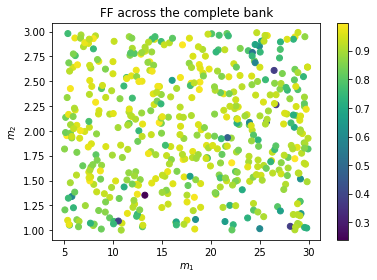

In [139]:
fig1, ax1 = plt.subplots()

sg_m1 = [x.m1 for x in sg]
sg_m2 = [x.m2 for x in sg]    
#im = plt.tricontourf(sg_m1, sg_m2, signal_matches)
im = plt.scatter(sg_m1, sg_m2, c = ff_array)
#im = plt.scatter(sg_m1, sg_m2, c = signal_matches)
#plt.plot(sg_m1, sg_m2, 'x', color='red')
fig1.colorbar(im)
plt.xlabel('$m_1$')
plt.ylabel('$m_2$')
plt.title('FF across the complete bank')
plt.savefig('plots/ff_complete_bank_50.png', dpi = 600)

0.9991977337028988


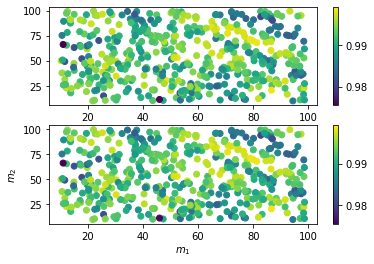

In [365]:
axes = gridspec.GridSpec(2,1)
plt.figure()

sg_m1 = [x.m1 for x in sg]
sg_m2 = [x.m2 for x in sg]    


ax1 = plt.subplot(axes[0,0])
im1 = plt.scatter(sg_m1, sg_m2, c = signal_matches)
plt.colorbar(im1)

ax2 = plt.subplot(axes[1,0])
im2 = plt.scatter(sg_m1, sg_m2, c = ff_array)
plt.colorbar(im2)
plt.xlabel('$m_1$')
plt.ylabel('$m_2$')
print(max(signal_matches))

50 51


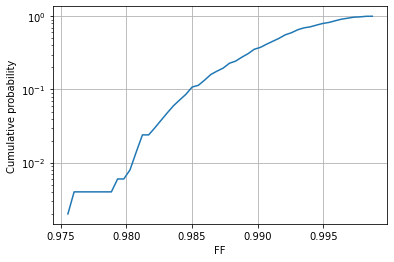

In [367]:
n, bins = np.histogram(signal_matches, density = True, bins=50)
cumulative = np.cumsum(n)*(bins[1]-bins[0])
print(len(cumulative), len(bins))
plt.yscale('log')
plt.plot(bins[:-1], cumulative)
plt.xlabel('FF')
plt.ylabel('Cumulative probability')
plt.grid()
plt.show()